# O PROBLEMA

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período 'diário', com intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Dica: utilize o maior intervalo de tempo possível para atingir maior acurácia no modelo preditivo.

Fonte: https://br.investing.com/indices/bovespa-historical-data

## Importando bibliotecas

In [70]:
import warnings 
warnings.filterwarnings(action = 'ignore')

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importando dados

In [72]:
df = pd.read_csv('Dados Históricos - Ibovespa.csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [74]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.03.2023,105.071,106.540,106.724,105.053,"19,17M","-1,38%"
1,08.03.2023,106.540,104.228,106.721,104.228,"15,90M","2,22%"
2,07.03.2023,104.228,104.700,105.179,103.480,"12,58M","-0,45%"
3,06.03.2023,104.700,103.865,105.171,103.170,"14,28M","0,80%"
4,03.03.2023,103.866,103.326,104.440,103.323,"13,10M","0,52%"


## Tratamento de dados

In [75]:
#verificando ocorrência de dados nulos
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [76]:
df[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1756,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [77]:
df.drop(1860, inplace = True)
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [78]:
#verificando valores duplicados
df.duplicated().sum()

0

In [79]:
#verificando ocorrência de espaçamentos
espacamento_encontrado = False

for column in df.columns:
    for index, value in df[column].items():
        if isinstance(value, str) and value.isspace():
            print(f'Espaçamento encontrado na coluna "{column}", linha {index}.')
            espacamento_encontrado = True

if not espacamento_encontrado:
    print('Não há espaçamento nos dados.')

Não há espaçamento nos dados.


In [80]:
#renomeando colunas
df.rename(columns = {
    'Data': 'data', 
    'Último': 'ultimo', 
    'Abertura': 'abertura', 
    'Máxima': 'maxima', 
    'Mínima': 'minima', 
    'Vol.': 'volume', 
    'Var%': 
    'variacao'}, inplace = True)
df.columns

Index(['data', 'ultimo', 'abertura', 'maxima', 'minima', 'volume', 'variacao'], dtype='object')

In [81]:
#alterando tipo da coluna de data
df['volume'] = df['volume'].str.replace(',', '.')
df['volume'] = df['volume'].str.replace('K', '')
df['volume'] = df['volume'].str.replace('M', '').astype(float)
df['variacao'] = df['variacao'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace('%', '').astype(float)
df['data'] = df['data'].str.replace('.', '-')
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')

In [82]:
df.head(3)

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-03-09,105.071,106.540,106.724,105.053,19.17,-1.38
1,2023-03-08,106.540,104.228,106.721,104.228,15.90,2.22
2,2023-03-07,104.228,104.700,105.179,103.480,12.58,-0.45


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      4999 non-null   datetime64[ns]
 1   ultimo    4999 non-null   float64       
 2   abertura  4999 non-null   float64       
 3   maxima    4999 non-null   float64       
 4   minima    4999 non-null   float64       
 5   volume    4998 non-null   float64       
 6   variacao  4999 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 312.4 KB


In [84]:
df.set_index('data', inplace = True)
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-03-09,105.071,106.540,106.724,105.053,19.17,-1.38
2023-03-08,106.540,104.228,106.721,104.228,15.90,2.22
2023-03-07,104.228,104.700,105.179,103.480,12.58,-0.45
2023-03-06,104.700,103.865,105.171,103.170,14.28,0.80
2023-03-03,103.866,103.326,104.440,103.323,13.10,0.52


In [85]:
df.describe()

,ultimo,abertura,maxima,minima,volume,variacao
count,4999.000000,4999.000000,4999.000000,4999.000000,4998.000000,4999.000000
mean,62.256559,62.238726,62.874926,61.605226,59.338129,0.059088
std,28.202934,28.205272,28.422833,27.974319,133.055927,1.720100
min,9.995000,10.006000,10.151000,9.968000,1.000000,-14.780000
25%,45.480000,45.469000,45.972000,44.994500,2.900000,-0.850000
50%,58.083000,58.076000,58.634000,57.534000,4.620000,0.090000
75%,76.042000,76.021500,76.698000,75.307500,17.682500,1.010000
max,130.776000,130.776000,131.190000,129.526000,999.460000,14.660000


## Teste estatístico de estacionariedade para a variável target

### ADF - Augmented Dickey-Fuller

>H0 - Hipótese Nula (não é estacionária)

>H1 - Hipótese Alternativa (rejeita a hipótese nula)

**p-valor <= 0.05 rejeitamos H0 com um nível de confiança de 95%**

In [86]:
from statsmodels.tsa.stattools import adfuller

In [87]:
X = df.ultimo.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -1.3014557118467227
P-valor: 0.6285060608534032
Valores críticos:
	1%: -3.431661944885779
	5%: -2.8621197374408225
	10%: -2.5670785949998973


## EDA

### Decompondo a série

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose #lib para decompor série temporal
from statsmodels.tsa.stattools import acf, pacf #autocorrelação e autocorrelação parcial

In [89]:
df_fechamento = df['ultimo'].to_frame()

In [90]:
df_fechamento.sort_index(inplace = True)

In [91]:
resultados = seasonal_decompose(df_fechamento, period = 7)

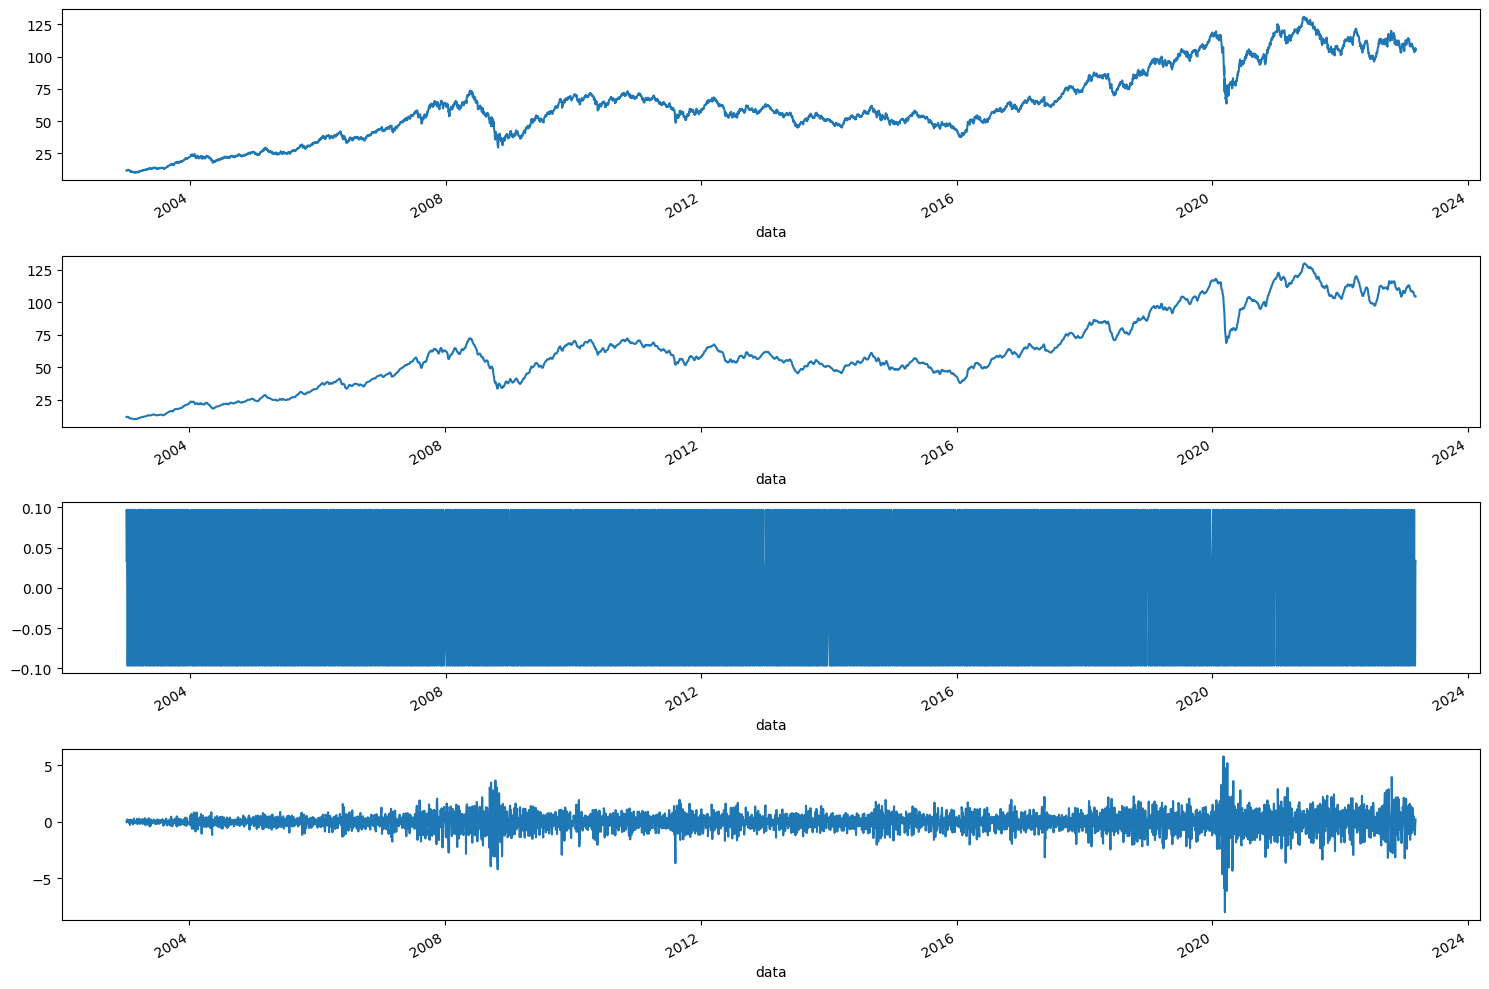

In [92]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax = ax1)
resultados.trend.plot(ax = ax2)
resultados.seasonal.plot(ax = ax3)
resultados.resid.plot(ax = ax4)
plt.tight_layout()

### Distribuição das variáveis

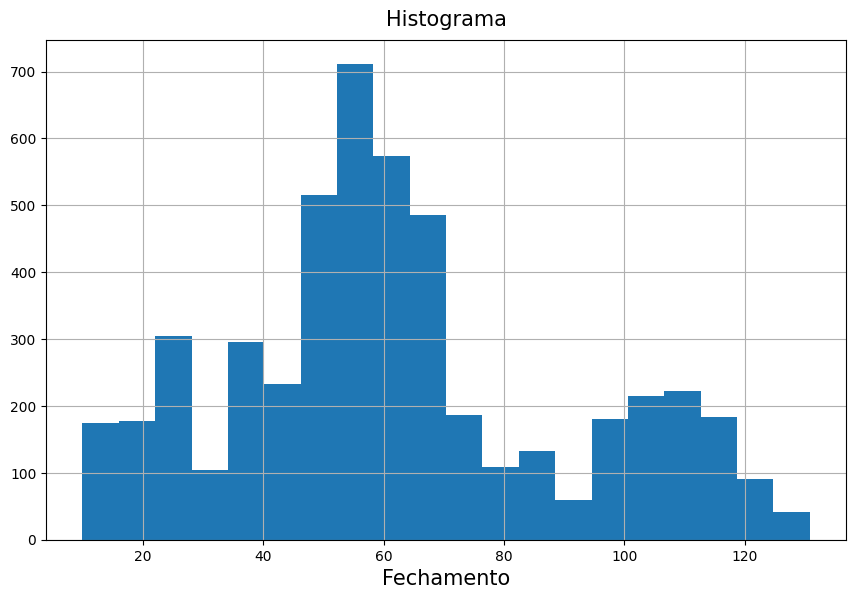

In [93]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.hist(df['ultimo'], bins=20)
eixo.set_title('Histograma', fontsize = 15, pad = 10)
eixo.set_xlabel('Fechamento', fontsize = 15)
eixo.grid(True)

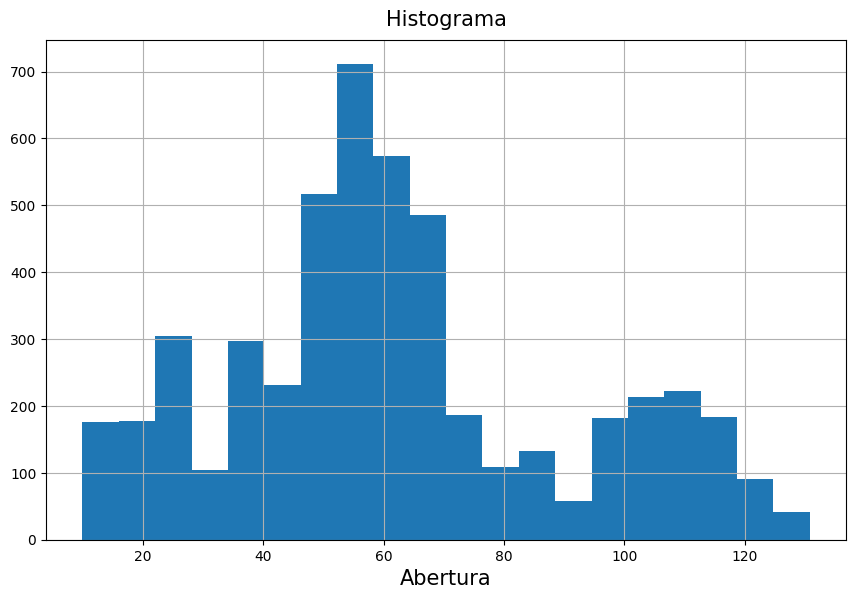

In [94]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.hist(df['abertura'], bins = 20)
eixo.set_title('Histograma', fontsize = 15, pad = 10)
eixo.set_xlabel('Abertura', fontsize = 15)
eixo.grid(True)

[Text(1, 0, 'Volume')]

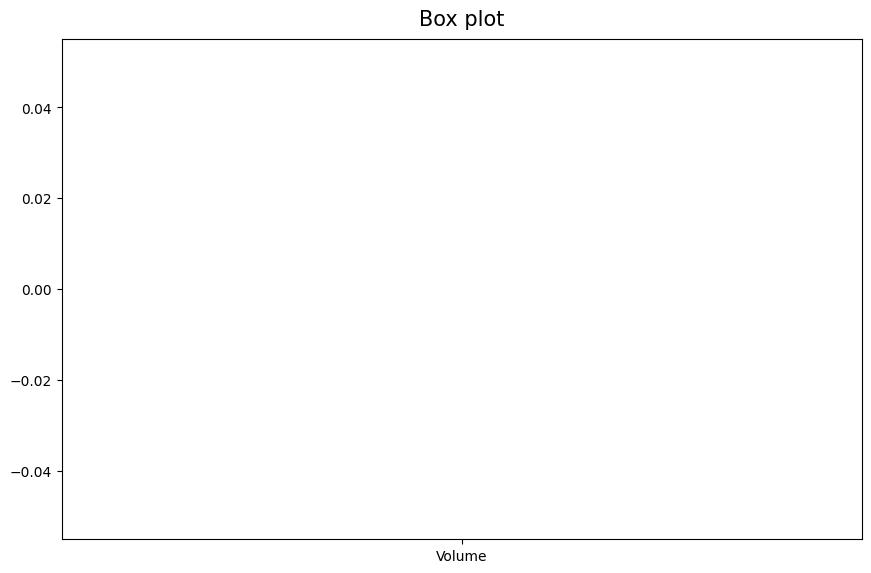

In [95]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.boxplot(df['volume'])
eixo.set_title('Box plot', fontsize = 15, pad = 10)
eixo.set_xticklabels(['Volume'])

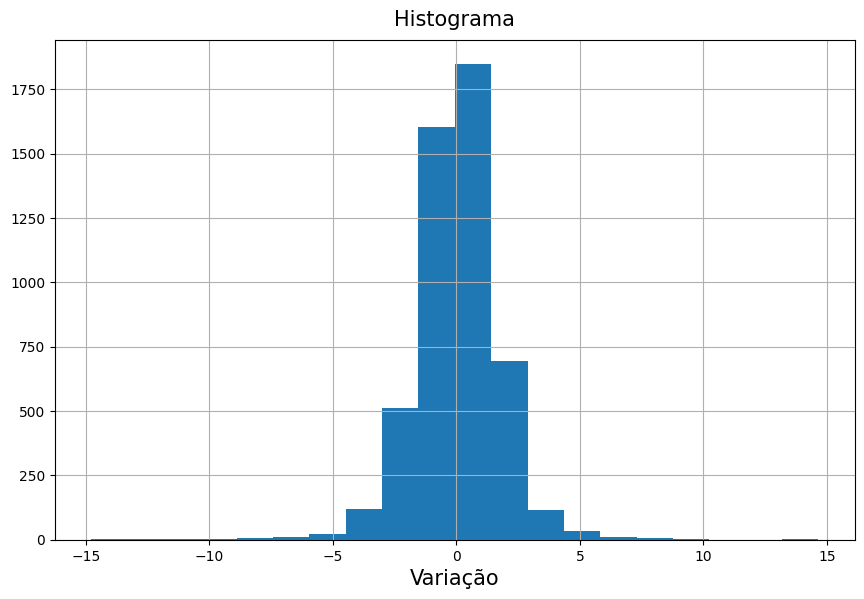

In [96]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.hist(df['variacao'], bins = 20)
eixo.set_title('Histograma', fontsize = 15, pad = 10)
eixo.set_xlabel('Variação', fontsize = 15)
eixo.grid(True)

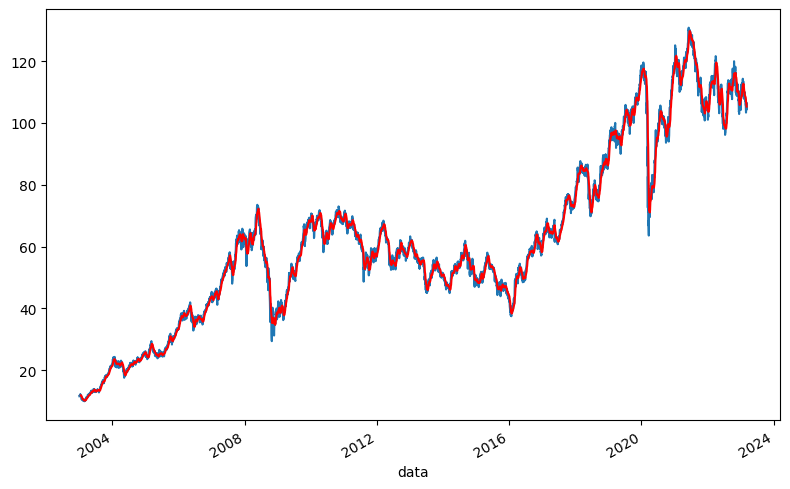

In [97]:
ma = df_fechamento.rolling(12).mean()

fig, ax = plt.subplots(figsize = (8, 5))
df_fechamento.plot(ax = ax, legend = False)
ma.plot(ax = ax, legend = False, color = 'r')
plt.tight_layout()

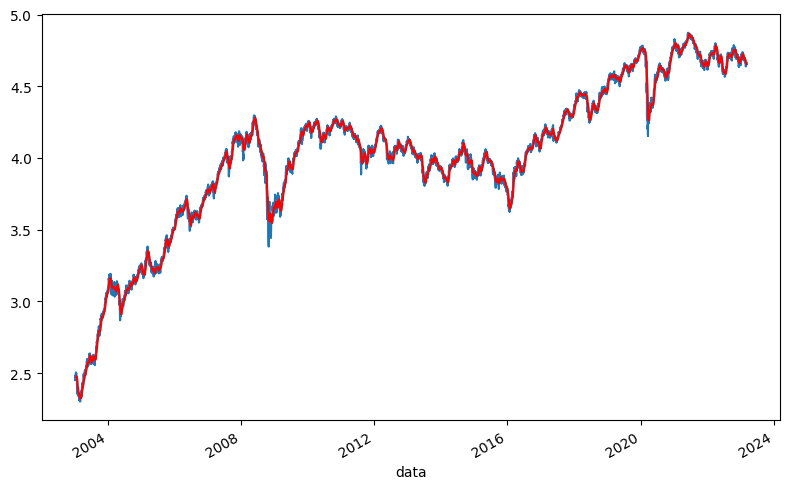

In [98]:
df_log = np.log(df_fechamento)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize = (8, 5))
df_log.plot(ax = ax, legend = False)
ma_log.plot(ax = ax, legend = False, color = 'r')
plt.tight_layout()

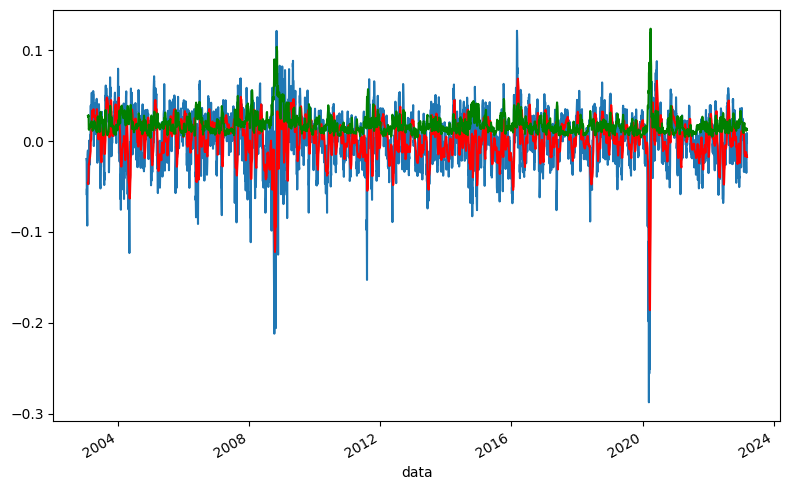

In [99]:
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std_s = df_s.rolling(12).std()

f, ax = plt.subplots(figsize = (8, 5))
df_s.plot(ax = ax, legend = False)
ma_s.plot(ax = ax, legend = False, color = 'r')
std_s.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()

In [100]:
X_s = df_s.ultimo.values

result_s = adfuller(X_s)

print('Teste ADF')
print(f'Teste estatístico: {result_s[0]}')
print(f'P-valor: {result_s[1]}')
print(f'Valores críticos:')

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -13.044124878423757
P-valor: 2.209832725278e-24
Valores críticos:
	1%: -3.4316669649844727
	5%: -2.8621219552891963
	10%: -2.5670797756478825


Teste ADF
Teste estatístico: -18.96917044526893
P-valor: 0.0
Valores críticos:
	1%: -3.431670688657576
	5%: -2.862123600382394
	10%: -2.567080651396155


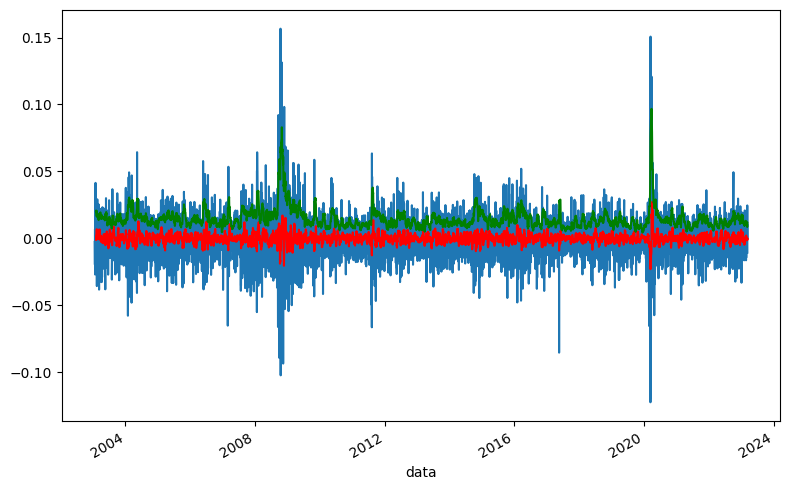

In [101]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots(figsize = (8, 5))
df_diff.plot(ax = ax, legend = False)
ma_diff.plot(ax = ax, legend = False, color = 'r')
std_diff.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()

X_diff = df_diff.ultimo.dropna().values

result_diff = adfuller(X_diff)

print('Teste ADF')
print(f'Teste estatístico: {result_diff[0]}')
print(f'P-valor: {result_diff[1]}')
print(f'Valores críticos:')

for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

### ARIMA - AR (autoregressivo) I (integrado) MA (média móvel)

#### A (x, y, z) -> ACF, PACF

In [102]:
lag_acf = acf(df_diff.dropna(), nlags = 25) #trabalhando na base mensal
lag_pacf = pacf(df_diff.dropna(), nlags = 25)

### 5% ACF

##### 1.96 / sqrt(N - d) -> N (número de pontos da base), d (número de vezes que diferenciamos a base)

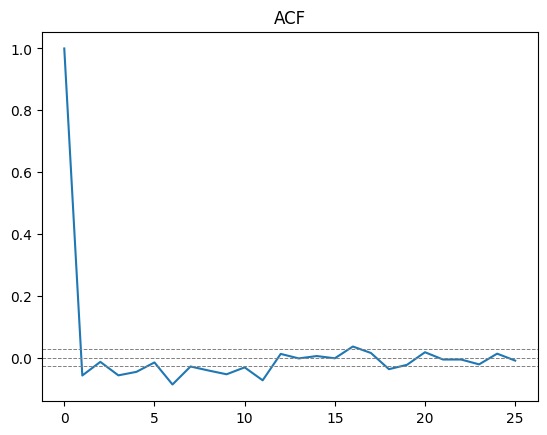

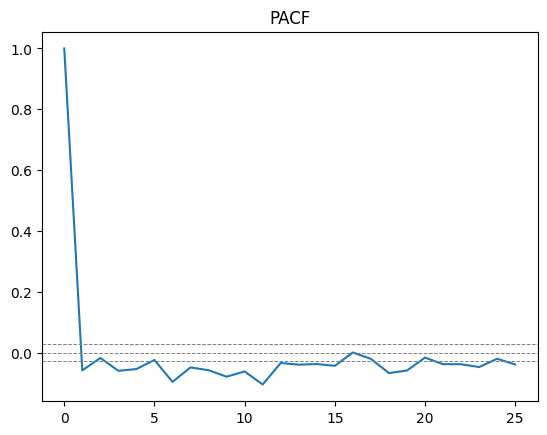

In [103]:
plt.plot(lag_acf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('ACF')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('PACF')
plt.show()

## Modelando

In [104]:
df_diff

,ultimo
data,
2003-01-17,NaN
2003-01-20,-0.002724
2003-01-21,-0.017262
2003-01-22,-0.019636
2003-01-23,0.006960
...,...
2023-03-03,0.009108
2023-03-06,0.010467
2023-03-07,-0.000330


In [105]:
df_diff.reset_index(inplace = True)
df_diff = df_diff[['data', 'ultimo']].rename(columns = {'data': 'ds', 'ultimo': 'y'})
df_diff['unique_id'] = 'Fechamento'
df_diff.dropna(inplace = True)
df_diff

,ds,y,unique_id
1,2003-01-20,-0.002724,Fechamento
2,2003-01-21,-0.017262,Fechamento
3,2003-01-22,-0.019636,Fechamento
4,2003-01-23,0.006960,Fechamento
5,2003-01-24,-0.027048,Fechamento
...,...,...,...
4983,2023-03-03,0.009108,Fechamento
4984,2023-03-06,0.010467,Fechamento
4985,2023-03-07,-0.000330,Fechamento
4986,2023-03-08,0.024558,Fechamento


In [142]:
df_diff.shape

(4987, 3)

In [106]:
df.reset_index(inplace = True)
df = df[['data', 'ultimo']].rename(columns = {'data': 'ds', 'ultimo': 'y'})
df['unique_id'] = 'Fechamento'
df

,ds,y,unique_id
0,2023-03-09,105.071,Fechamento
1,2023-03-08,106.540,Fechamento
2,2023-03-07,104.228,Fechamento
3,2023-03-06,104.700,Fechamento
4,2023-03-03,103.866,Fechamento
...,...,...,...
4994,2003-01-08,11.786,Fechamento
4995,2003-01-07,11.876,Fechamento
4996,2003-01-06,12.020,Fechamento
4997,2003-01-03,11.600,Fechamento


In [143]:
def wmape(y_test, y_pred):
    return np.abs(y_test - y_pred).sum() / np.abs(y_test).sum()

### Modelo baseline

In [108]:
from statsforecast import StatsForecast
from statsforecast.models import Naive

In [109]:
df.shape

(4999, 3)

In [150]:
treino = df_diff.loc[df_diff['ds'] < '2022-12-01'] #dados de treino
valid = df_diff[(df_diff['ds'] >= '2022-12-01') & (df_diff['ds'] < '2023-03-09')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid['ds'].nunique() #datas distintas no intervalo (90 dias)
h

67

In [151]:
valid.shape

(67, 3)

In [152]:
treino.shape

(4919, 3)

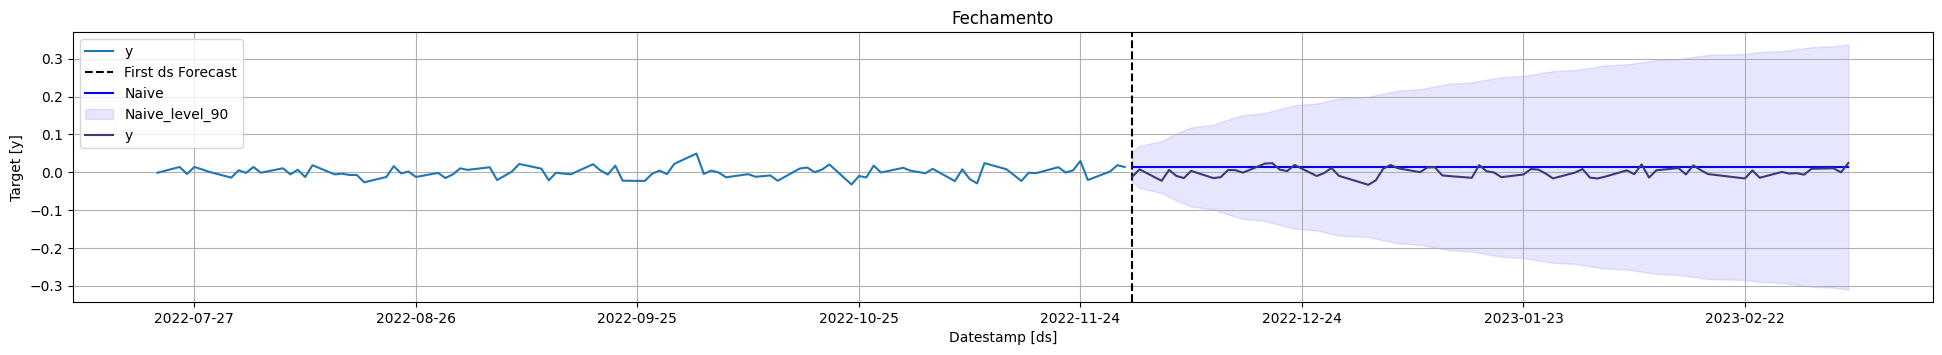

In [174]:
model = StatsForecast(
    models = [Naive()], 
    freq = 'D', 
    n_jobs = -1) #n_jobs, quantidade de CPUs da máquina que será ultilizada

model.fit(treino)
forecast_df = model.predict(h = h, level = [90]) #level é a banda de confiança estabelecida
forecast_df.ds = valid.ds.to_list()
forecast_df = forecast_df.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model.plot(treino, forecast_df, level = [90], engine = 'matplotlib', max_insample_length = 90)

In [175]:
forecast_df.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,Fechamento,2022-12-01,0.013937,-0.025592,0.053466,-0.012303
1,Fechamento,2022-12-02,0.013937,-0.041965,0.069839,0.007696
2,Fechamento,2022-12-05,0.013937,-0.054529,0.082403,-0.022570
3,Fechamento,2022-12-06,0.013937,-0.065121,0.092995,0.006173
4,Fechamento,2022-12-07,0.013937,-0.074452,0.102326,-0.009699


In [115]:
forecast_df.dropna(inplace = True)

In [116]:
forecast_df.shape

(67, 6)

In [176]:
wmape_baseline = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f'WMAPE: {wmape_baseline:.2%}')

WMAPE: 151.80%


### Modelo baseline com sazonalidade

In [118]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive

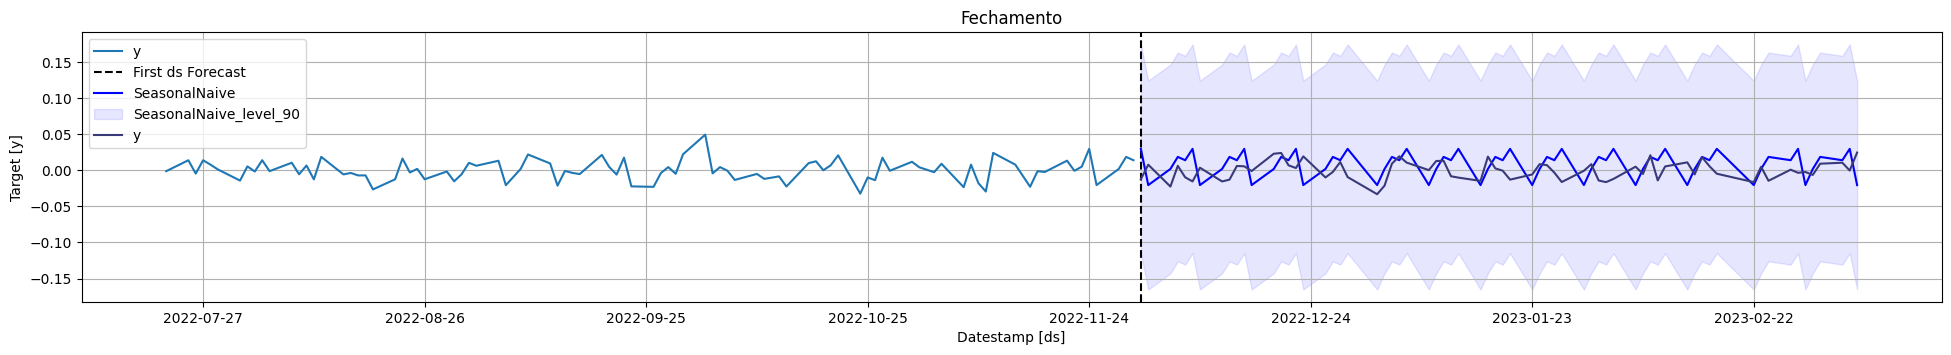

In [177]:
model_s = StatsForecast(models = [SeasonalNaive(season_length = 5)], freq = 'D', n_jobs = -1) #o parâmetro season_length é o padrão que se deseja estabelecer
model_s.fit(treino)
forecast_dfs = model_s.predict(h = h, level = [90])
forecast_dfs.ds = valid.ds.to_list()
forecast_dfs = forecast_dfs.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_s.plot(treino, forecast_dfs, level = [90], engine = 'matplotlib', max_insample_length = 90)

In [178]:
forecast_dfs.shape

(67, 6)

In [179]:
forecast_dfs.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,y
0,Fechamento,2022-12-01,0.029677,-0.114968,0.174321,-0.012303
1,Fechamento,2022-12-02,-0.020533,-0.165177,0.124112,0.007696
2,Fechamento,2022-12-05,0.001806,-0.142839,0.146450,-0.022570
3,Fechamento,2022-12-06,0.018516,-0.126129,0.163161,0.006173
4,Fechamento,2022-12-07,0.013937,-0.130708,0.158581,-0.009699


In [165]:
forecast_dfs.dropna(inplace = True)

In [180]:
wmape_s = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f'WMAPE: {wmape_s:.2%}')

WMAPE: 191.71%


### Modelo baseline com sazonalidade e média móvel

In [123]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage

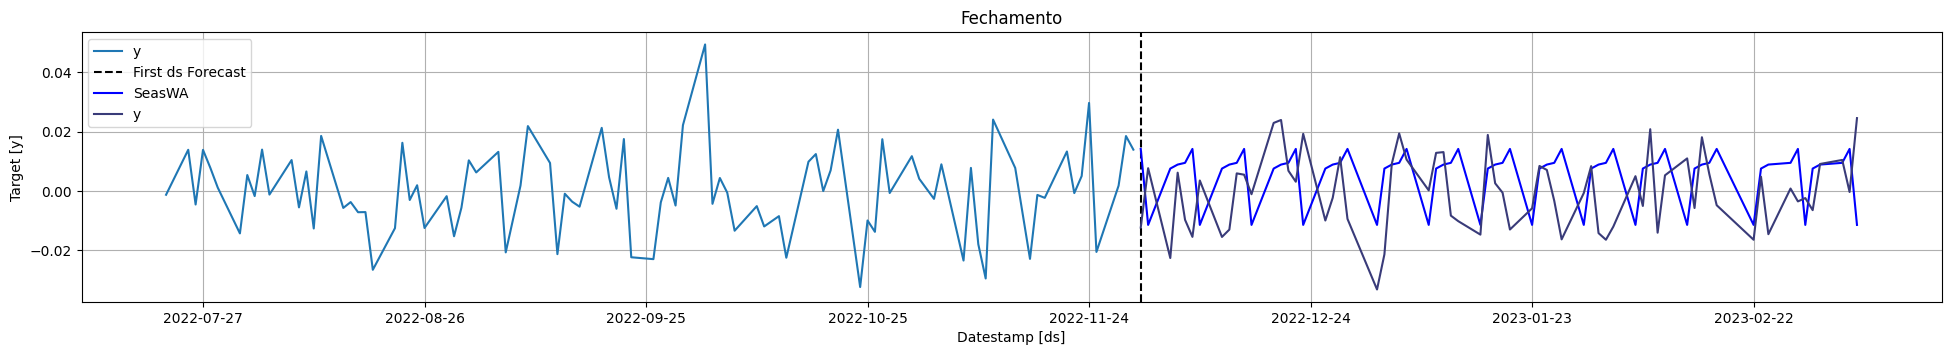

In [181]:
model_sm = StatsForecast(models = [SeasonalWindowAverage(season_length = 5, window_size = 2)], freq = 'D', n_jobs = -1) #o parâmetro window_size é período em que será calculada a média móvel (2 semanas)
model_sm.fit(treino)
forecast_dfsm = model_sm.predict(h = h, level = [90])
forecast_dfsm.ds = valid.ds.to_list()
forecast_dfsm = forecast_dfsm.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_sm.plot(treino, forecast_dfsm, level = [90], engine = 'matplotlib', max_insample_length = 90)

In [171]:
forecast_dfsm.head()

,unique_id,ds,SeasWA,y
0,Fechamento,2022-12-01,0.014181,-0.012303
1,Fechamento,2022-12-02,-0.011421,0.007696
2,Fechamento,2022-12-05,0.007560,-0.022570
3,Fechamento,2022-12-06,0.008908,0.006173
4,Fechamento,2022-12-07,0.009490,-0.009699


In [126]:
forecast_dfsm.dropna(inplace = True)

In [182]:
wmape_sm = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f'WMAPE: {wmape_sm:.2%}')

WMAPE: 134.28%


### Modelo ARIMA

In [128]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

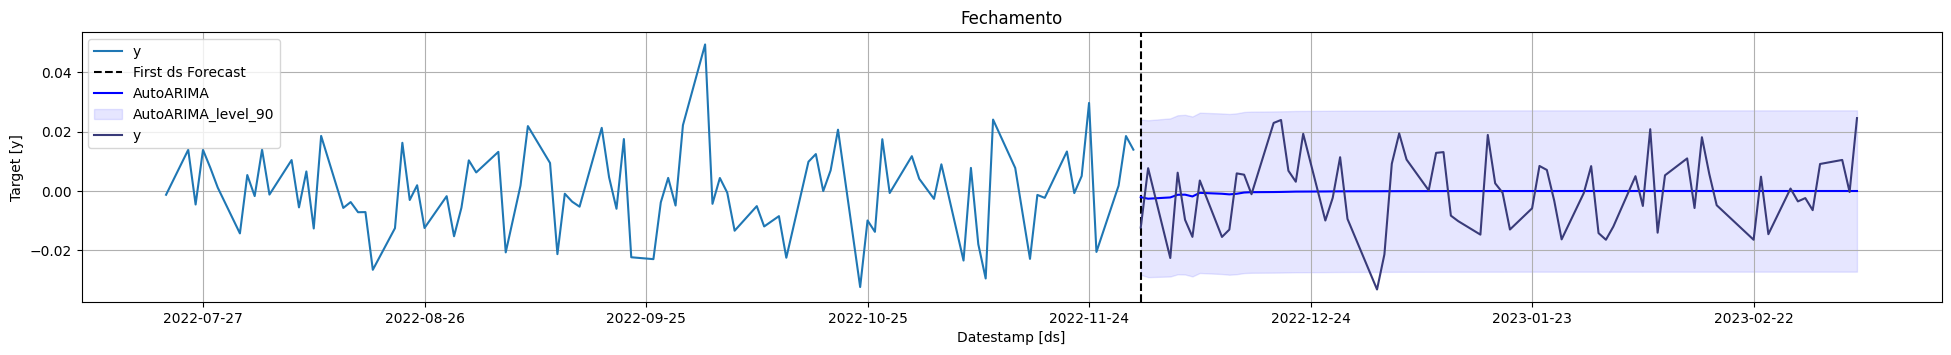

In [183]:
model_a = StatsForecast(models = [AutoARIMA(season_length = 5)], freq = 'D', n_jobs = -1)
model_a.fit(treino)
forecast_dfa = model_a.predict(h = h, level = [90])
forecast_dfa.ds = valid.ds.to_list()
forecast_dfa = forecast_dfa.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_a.plot(treino, forecast_dfa, level = [90], engine = 'matplotlib', max_insample_length = 90)

In [130]:
forecast_dfa.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,Fechamento,2022-12-01,0.001054,-0.025000,0.027108,-0.012303
1,Fechamento,2022-12-02,0.000642,-0.025709,0.026992,0.007696
2,Fechamento,2022-12-05,0.000460,-0.026102,0.027021,-0.022570
3,Fechamento,2022-12-06,0.000869,-0.025844,0.027581,0.006173
4,Fechamento,2022-12-07,0.000216,-0.026605,0.027036,-0.009699


In [131]:
forecast_dfa.dropna(inplace = True)

In [184]:
wmape_a = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 99.60%


### Auto ARIMA

In [185]:
from pmdarima.arima import auto_arima

In [187]:
stepwise_model = auto_arima(df.drop('unique_id', axis = 1).set_index('ds', drop = True), start_p = 1, start_q = 1,
                           max_p = 3, max_q = 3, m = 12,
                           start_P = 0, seasonal = True,
                           d = 1, D = 1, trace = True,
                           error_action = 'ignore',  
                           suppress_warnings = True, 
                           stepwise = True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=41.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18360.563, Time=1.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16887.166, Time=5.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=55.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18330.480, Time=1.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16335.132, Time=19.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=67.96 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=10.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16358.599, Time=2.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=16336.654, Time=4.39 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=16336.433, Time=6.54 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=16335.680, Time=5.22 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=16338.411, Time=13.55 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=16337.129, Time=18.04 sec

Best model:  ARIMA(1,

In [189]:
treino = treino.drop('unique_id', axis = 1).set_index('ds', drop = True)

In [190]:
stepwise_model.fit(treino)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
valid.shape

(67, 3)

In [191]:
future_forecast = stepwise_model.predict(n_periods = 67)

In [192]:
valid.reset_index(inplace = True, drop = True)

In [193]:
valid.drop('unique_id', axis = 1, inplace = True)

In [194]:
valid.set_index('ds', inplace = True)

In [196]:
valid.head()

,y
ds,
2022-12-01,-0.012303
2022-12-02,0.007696
2022-12-05,-0.022570
2022-12-06,0.006173
2022-12-07,-0.009699


<Axes: xlabel='ds'>

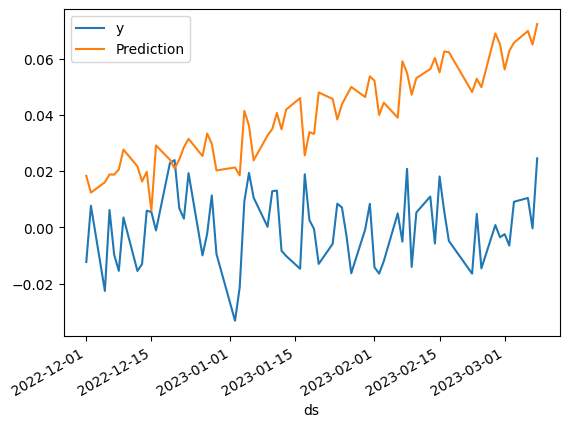

In [197]:
future_forecast = pd.DataFrame(future_forecast.values, index = valid.index, columns = ['Prediction'])

pd.concat([valid, future_forecast], axis = 1).plot()

<Axes: xlabel='ds'>

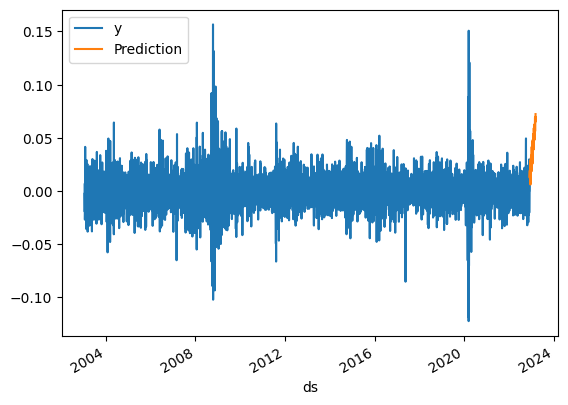

In [198]:
pd.concat([treino, future_forecast], axis = 1).plot()